# Часть первая, с блекджеком и стратегиями

Правила блекджека достаточно просты;
давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
*  численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
* туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
*  игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
* игрок может совершать одно из двух действий:
** hit  — взять ещё одну карту;
** stand — не брать больше карт;
* если сумма очков у игрока на руках больше 21, он проигрывает (bust);
* если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
* после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
* в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).


## Задание 1
Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit.
Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.


Card Values:

    Face cards (Jack, Queen, King) have a point value of 10.

    Aces can either count as 11 (called a ‘usable ace’) or 1.

    Numerical cards (2-9) have a value equal to their number.


In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from itertools import product
import random
from collections import defaultdict
from tqdm.autonotebook import tqdm
from blackjack import BlackjackEnv
from functools import partialmethod

/var/folders/n7/qnb2yzw97rjf7x2362tbh_t00000gn/T/ipykernel_10689/458493977.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
env = BlackjackEnv(natural = True)
type(env)

blackjack.BlackjackEnv

In [5]:
def play_game(env, strategy):
    # sum_hand, dealer, usable_ace
    observation = env.reset()[0]
    terminated = False
    G = 0
    while not terminated:
        # There are two actions: stick (0), and hit (1).
        action = strategy(observation)
        observation, reward, terminated, _, _ = env.step(action)
        G += reward
    return G

def simple_strategy(observation):
    usable_ace = observation[0] + 10 * int(observation[2]) not in (19, 20, 21)
    not_usable_ace = observation[0] not in (19, 20, 21)
    return int(usable_ace or not_usable_ace)


def play_games(env, strategy=simple_strategy, n=100_000, verbose=True):
    rewards = []
    if verbose:
        i = tqdm(range(n))
    else:
        i = range(n)
    for _ in i:
        reward = play_game(env, strategy)
        rewards.append(reward)
    return np.mean(rewards)

In [12]:
play_games(env, strategy=simple_strategy, n=100_000)

  0%|          | 0/100000 [00:00<?, ?it/s]

-0.27671

Данная стратегия проигрышная, мы в минусе

# Задание 2
Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.

In [13]:
S = []
for i in range(1 + 1 + 2, 11 + 11 + 10):
    for j in range(1, 11):
        for k in (True, False):
            if not k or (k and 12 <= i <= 21):
                S.append((i, j, k))
state_index = {state: i for i, state in enumerate(S)}

In [32]:
def get_action_Q(Q):
    return np.argmax(Q, axis=1)

def play_game_Q(env, Q, action_space=(0, 1), alpha=0.05, epsilon=0.1, gamma=1):
    observation = env.reset()[0]
    index = state_index[observation]
    terminated = False

    while not terminated:
        action = get_action_Q(Q)[index] if random.random() < (1 - epsilon) else random.choice(action_space)
        observation, reward, terminated, _, _ = env.step(action)
        index_new = state_index[observation]
        Q[index, action] = Q[index, action] + alpha * (reward + gamma * max(Q[index_new]) - Q[index, action])
        index = index_new
    return Q

def q_learning(env, Q, games=10_000, action_space=(0, 1), alpha=0.01, epsilon=0.01, gamma=1, verbose=True):
    if verbose:
        i = tqdm(range(games))
    else:
        i = range(games)
    for _ in i:
        Q = play_game_Q(env=env, Q=Q, action_space=action_space, alpha=alpha, epsilon=epsilon, gamma=gamma)
    return Q

In [28]:
num_comb = len(list(product(range(1 + 1 + 2, 11 + 11 + 10), range(1, 11), (True, False))))
Q = np.zeros((len(S), 2))
Q = q_learning(env, Q, games=100_000, alpha=0.01, epsilon=0.1)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [29]:
def Q_strategy(observation):
    return np.argmax(Q, axis=1)[state_index[observation]]

play_games(env, strategy=Q_strategy, n=100_000)

  0%|          | 0/100000 [00:00<?, ?it/s]

-0.15732

Уже лучше, но всё равно в минусе :(

## Задание 3
Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [21]:
import optuna

def objective(trial):
    alpha = trial.suggest_loguniform('alpha', 0.0001, 0.1)
    epsilon = trial.suggest_float('epsilon', 0, 1)
    Q = np.zeros((len(S), 2))
    Q = q_learning(env, Q, games=100_000, alpha=alpha, epsilon=epsilon, verbose=False)
    return play_games(env, strategy=Q_strategy, n=10_000, verbose=False)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200, n_jobs=1, show_progress_bar=True, )

study.best_params

[I 2022-12-30 18:49:05,636] A new study created in memory with name: no-name-71349c31-743a-46b4-ad81-451630dfd79b


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/n7/qnb2yzw97rjf7x2362tbh_t00000gn/T/ipykernel_10689/2276950518.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_loguniform('alpha', 0.0001, 0.1)


[I 2022-12-30 18:49:08,336] Trial 0 finished with value: -0.1022 and parameters: {'alpha': 0.030788923390275603, 'epsilon': 0.19805717712715143}. Best is trial 0 with value: -0.1022.
[I 2022-12-30 18:49:10,452] Trial 1 finished with value: -0.0995 and parameters: {'alpha': 0.0027288383622486585, 'epsilon': 0.8209015084749883}. Best is trial 1 with value: -0.0995.
[I 2022-12-30 18:49:12,593] Trial 2 finished with value: -0.0968 and parameters: {'alpha': 0.00019169113850012222, 'epsilon': 0.767962367989283}. Best is trial 2 with value: -0.0968.
[I 2022-12-30 18:49:14,752] Trial 3 finished with value: -0.0805 and parameters: {'alpha': 0.02450558219154915, 'epsilon': 0.5644831239808199}. Best is trial 3 with value: -0.0805.
[I 2022-12-30 18:49:16,906] Trial 4 finished with value: -0.0731 and parameters: {'alpha': 0.060433137246401945, 'epsilon': 0.6718063564040341}. Best is trial 4 with value: -0.0731.
[I 2022-12-30 18:49:19,126] Trial 5 finished with value: -0.0791 and parameters: {'alpha

{'alpha': 0.005836224427843307, 'epsilon': 0.49017167110454873}

In [22]:
study.best_params

{'alpha': 0.005836224427843307, 'epsilon': 0.49017167110454873}

In [25]:
num_comb = len(list(product(range(1 + 1 + 2, 11 + 11 + 10), range(1, 11), (True, False))))
Q = np.zeros((len(S), 2))
Q = q_learning(env, Q, games=100_000, alpha=0.005836224427843307, epsilon=0.49017167110454873)
rewards = []
for _ in tqdm(range(100_000)):
    reward = play_game(env, Q_strategy)
    rewards.append(reward)

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [27]:
print(np.mean(rewards))

-0.10405


Тюнинг помог улучшить результат, было -0.15732 стало -0.10405

<AxesSubplot: >

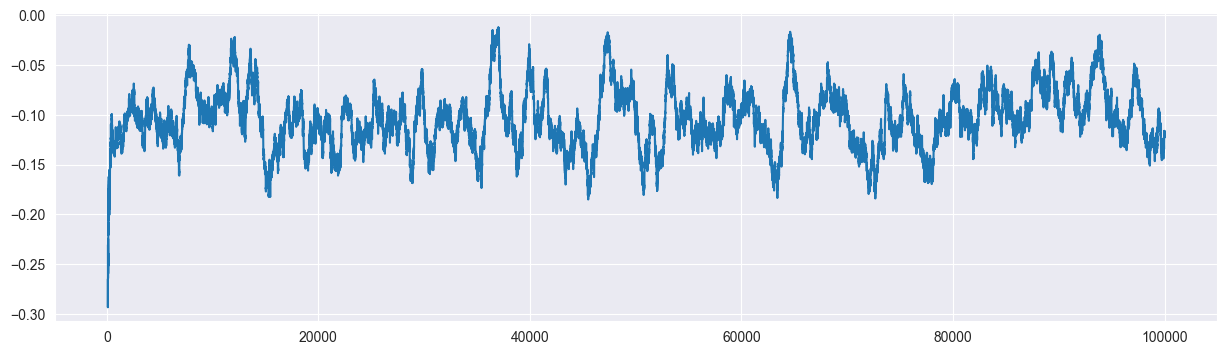

In [30]:
import pandas as pd

pd.Series(rewards).rolling(1000, step=1, min_periods=100).mean().plot(figsize=(15, 4), grid=True,)

# Часть вторая, удвоенная
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
*  double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.


## Задание 4
Реализуйте новый вариант блекджека на основе окружения BlackjackEnv из OpenAI Gym, в котором разрешено удвоение ставки.


In [31]:
from blackjack import BlackjackDoubleEnv

env = BlackjackDoubleEnv(natural = True)
type(env)

blackjack.BlackjackDoubleEnv

## Задание 5
Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [38]:
import optuna

def objective(trial):
    alpha = trial.suggest_loguniform('alpha', 0.0001, 0.1)
    epsilon = trial.suggest_float('epsilon', 0, 1)
    Q = np.zeros((len(S), 3))
    Q = q_learning(env, Q, games=5_000, alpha=alpha, epsilon=epsilon, verbose=False)
    return play_games(env, strategy=Q_strategy, n=5_000, verbose=False)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=1, show_progress_bar=True, )

study.best_params

[I 2022-12-30 19:10:56,424] A new study created in memory with name: no-name-868c6a55-cc3e-464b-9a87-41e75f6a386a


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/n7/qnb2yzw97rjf7x2362tbh_t00000gn/T/ipykernel_10689/149592238.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_loguniform('alpha', 0.0001, 0.1)


[I 2022-12-30 19:10:59,509] Trial 0 finished with value: -0.0358 and parameters: {'alpha': 0.006050197001427397, 'epsilon': 0.06584318440496872}. Best is trial 0 with value: -0.0358.
[I 2022-12-30 19:11:01,707] Trial 1 finished with value: -0.0431 and parameters: {'alpha': 0.0009807621955442547, 'epsilon': 0.4409339477129637}. Best is trial 0 with value: -0.0358.
[I 2022-12-30 19:11:03,867] Trial 2 finished with value: -0.0428 and parameters: {'alpha': 0.0032619167495650018, 'epsilon': 0.8185409447620223}. Best is trial 0 with value: -0.0358.
[I 2022-12-30 19:11:06,078] Trial 3 finished with value: -0.0554 and parameters: {'alpha': 0.005978003302123654, 'epsilon': 0.621647359717061}. Best is trial 0 with value: -0.0358.
[I 2022-12-30 19:11:08,153] Trial 4 finished with value: -0.0584 and parameters: {'alpha': 0.0212927670631696, 'epsilon': 0.8061305050152616}. Best is trial 0 with value: -0.0358.
[I 2022-12-30 19:11:10,328] Trial 5 finished with value: -0.0022 and parameters: {'alpha':

{'alpha': 0.009079818476637426, 'epsilon': 0.12217629622429504}

In [39]:
num_comb = len(list(product(range(1 + 1 + 2, 11 + 11 + 10), range(1, 11), (True, False))))
Q = np.zeros((len(S), 3))
Q = q_learning(env, Q, games=100_000, alpha=0.009079818476637426, epsilon=0.12217629622429504)
rewards = []
for _ in tqdm(range(100_000)):
    reward = play_game(env, Q_strategy)
    rewards.append(reward)

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

<AxesSubplot: >

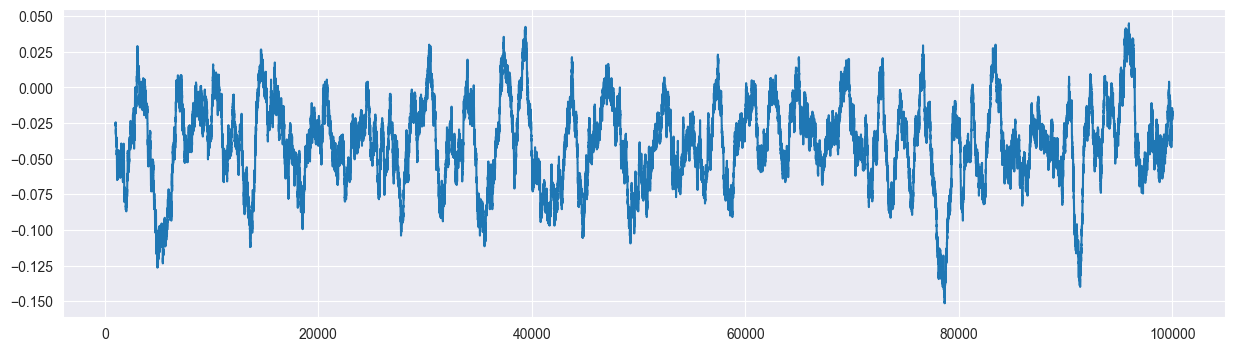

In [42]:
pd.Series(rewards).rolling(1000, step=1, min_periods=1000).mean().plot(figsize=(15, 4), grid=True,)

In [43]:
print(np.mean(rewards))

-0.038925


Уже почти беспроигрышная стратегия